## NN Adv Assignment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/Tobigs/Week6/Test.csv')
test = pd.read_csv('/content/drive/MyDrive/Tobigs/Week6/Train.csv')

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

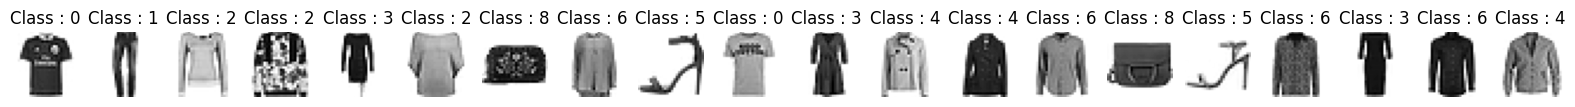

In [8]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [9]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

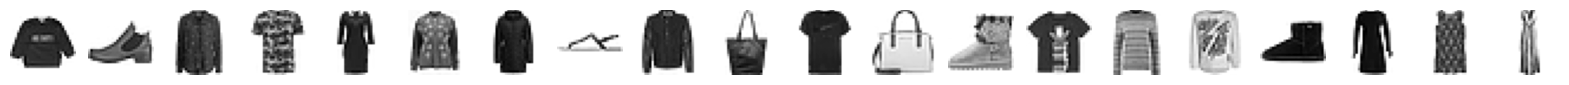

In [10]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [12]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cuda


In [13]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [15]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [16]:
def train(model, train_loader, optimizer):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [19]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

가중치 초기화(He)를 함수를 만들었다.

In [20]:
class MyNet_FC(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.bn5 = nn.BatchNorm1d(num_features=32)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.float()
        x = self.relu(self.bn1(self.fc1(x.view(-1, 784))))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)

model_FC = MyNet_FC().to(DEVICE)
model_FC.apply(initialize_weights)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer_FC = torch.optim.Adam(model_FC.parameters(), lr=0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

In [27]:
class MyNet_FC_dropout(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.bn5 = nn.BatchNorm1d(num_features=32)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.float()
        x = self.relu(self.bn1(self.fc1(x.view(-1, 784))))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = self.fc6(x)
        return F.log_softmax(x, dim=1)


model_FC_dropout = MyNet_FC_dropout().to(DEVICE)
model_FC_dropout.apply(initialize_weights)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer_FC_dropout = torch.optim.Adam(model_FC_dropout.parameters(), lr=0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

In [25]:
class MyNet_CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #여기에 layer들을 삽입: self.layer1 와 같이 Data Attribute로 nn 모듈의 Network 추가
        #Ex. self.layer1 = nn.Linear(100, 10)
        #자세한 것은 pytorch 공식문서 혹은 인터넷 예제 참고
        self.keep_prob = 0.5
        self.cl1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32 ,kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.cl2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.cl3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2 ,stride=2, padding=1)
        )
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        self.cl4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob)
        )
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.bn3 = nn.BatchNorm2d(num_features=128)

    def forward(self, x):
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x = x.float()
        out = self.bn1(self.cl1(x.view(-1, 1, 28, 28)))
        out = self.bn2(self.cl2(out))
        out = self.bn3(self.cl3(out))
        out = out.view(out.size(0), -1)
        out = self.cl4(out)
        out = self.fc2(out)
        return out

model_CNN = MyNet_CNN().to(DEVICE)
model_CNN.apply(initialize_weights)
#적절한 optimizer를 선택: torch.optim의 적절한 Optimizer를 사용
optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr=0.001)
#적절한 Loss function을 선택: nn 모듈의 Function을 사용
criterion = nn.CrossEntropyLoss()

[EPOCH: 1], 	Train Loss: 0.0851, 	Train Accuracy: 97.29 %, 	Val Loss: 0.5952, 	Val Accuracy: 85.05 % 

[EPOCH: 2], 	Train Loss: 0.0770, 	Train Accuracy: 97.30 %, 	Val Loss: 0.5574, 	Val Accuracy: 85.10 % 

[EPOCH: 3], 	Train Loss: 0.0739, 	Train Accuracy: 97.66 %, 	Val Loss: 0.5312, 	Val Accuracy: 85.70 % 

[EPOCH: 4], 	Train Loss: 0.0645, 	Train Accuracy: 97.84 %, 	Val Loss: 0.5619, 	Val Accuracy: 85.25 % 

[EPOCH: 5], 	Train Loss: 0.0540, 	Train Accuracy: 98.31 %, 	Val Loss: 0.4741, 	Val Accuracy: 86.55 % 

[EPOCH: 6], 	Train Loss: 0.0589, 	Train Accuracy: 98.09 %, 	Val Loss: 0.5167, 	Val Accuracy: 86.55 % 

[EPOCH: 7], 	Train Loss: 0.0741, 	Train Accuracy: 97.53 %, 	Val Loss: 0.6047, 	Val Accuracy: 85.35 % 

[EPOCH: 8], 	Train Loss: 0.0675, 	Train Accuracy: 97.76 %, 	Val Loss: 0.5962, 	Val Accuracy: 85.15 % 

[EPOCH: 9], 	Train Loss: 0.0733, 	Train Accuracy: 97.47 %, 	Val Loss: 0.5194, 	Val Accuracy: 85.60 % 

[EPOCH: 10], 	Train Loss: 0.0550, 	Train Accuracy: 98.30 %, 	Val Loss: 0.

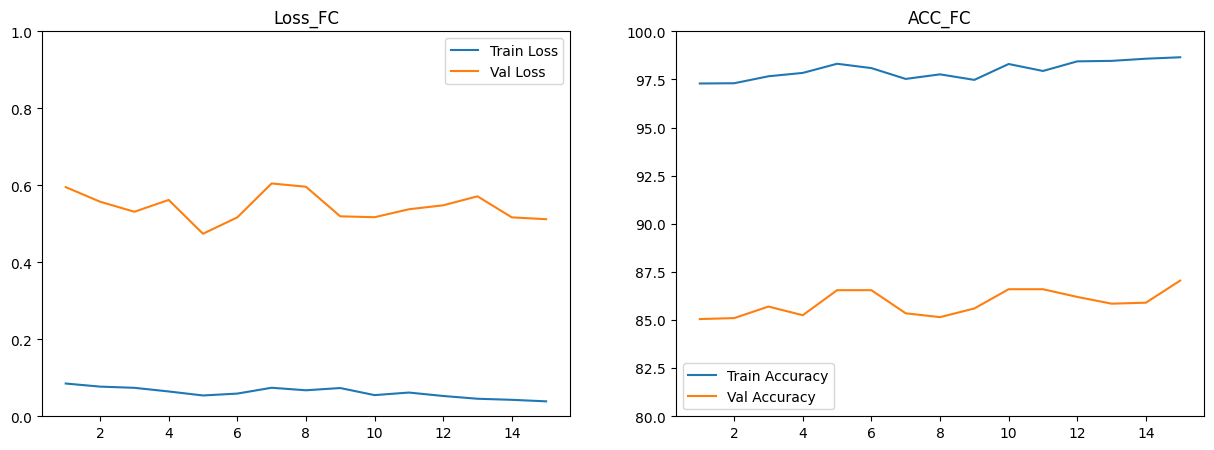

In [28]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model_FC, train_loader, optimizer_FC)
  val_loss, val_accuracy = evaluate(model_FC, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss_FC')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC_FC')

plt.show()

[EPOCH: 1], 	Train Loss: 1.6695, 	Train Accuracy: 45.45 %, 	Val Loss: 0.9505, 	Val Accuracy: 74.80 % 

[EPOCH: 2], 	Train Loss: 1.0578, 	Train Accuracy: 69.08 %, 	Val Loss: 0.6815, 	Val Accuracy: 80.00 % 

[EPOCH: 3], 	Train Loss: 0.8338, 	Train Accuracy: 75.36 %, 	Val Loss: 0.5273, 	Val Accuracy: 84.10 % 

[EPOCH: 4], 	Train Loss: 0.7130, 	Train Accuracy: 79.16 %, 	Val Loss: 0.4824, 	Val Accuracy: 84.00 % 

[EPOCH: 5], 	Train Loss: 0.6350, 	Train Accuracy: 81.05 %, 	Val Loss: 0.4985, 	Val Accuracy: 83.40 % 

[EPOCH: 6], 	Train Loss: 0.5745, 	Train Accuracy: 82.86 %, 	Val Loss: 0.4624, 	Val Accuracy: 83.95 % 

[EPOCH: 7], 	Train Loss: 0.5328, 	Train Accuracy: 84.06 %, 	Val Loss: 0.4215, 	Val Accuracy: 85.75 % 

[EPOCH: 8], 	Train Loss: 0.5097, 	Train Accuracy: 84.41 %, 	Val Loss: 0.4672, 	Val Accuracy: 84.65 % 

[EPOCH: 9], 	Train Loss: 0.4644, 	Train Accuracy: 86.11 %, 	Val Loss: 0.4045, 	Val Accuracy: 86.25 % 

[EPOCH: 10], 	Train Loss: 0.4411, 	Train Accuracy: 86.62 %, 	Val Loss: 0.

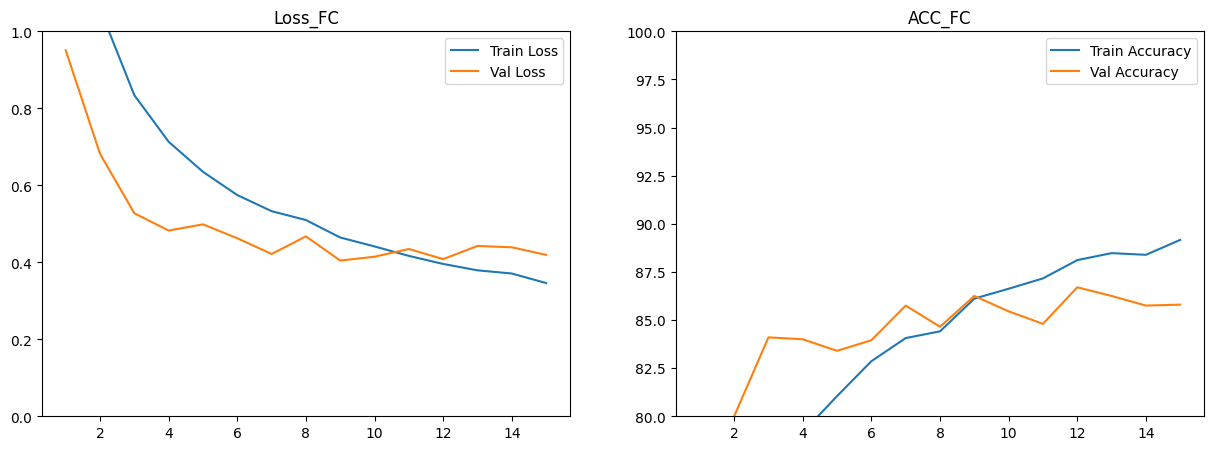

In [29]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model_FC_dropout, train_loader, optimizer_FC_dropout)
  val_loss, val_accuracy = evaluate(model_FC_dropout, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss_FC')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC_FC')

plt.show()

[EPOCH: 1], 	Train Loss: 0.0244, 	Train Accuracy: 99.28 %, 	Val Loss: 0.5433, 	Val Accuracy: 90.35 % 

[EPOCH: 2], 	Train Loss: 0.0325, 	Train Accuracy: 98.92 %, 	Val Loss: 0.5942, 	Val Accuracy: 90.10 % 

[EPOCH: 3], 	Train Loss: 0.0306, 	Train Accuracy: 99.04 %, 	Val Loss: 0.5805, 	Val Accuracy: 90.10 % 

[EPOCH: 4], 	Train Loss: 0.0260, 	Train Accuracy: 99.11 %, 	Val Loss: 0.7133, 	Val Accuracy: 90.10 % 

[EPOCH: 5], 	Train Loss: 0.0476, 	Train Accuracy: 98.66 %, 	Val Loss: 0.5736, 	Val Accuracy: 90.20 % 

[EPOCH: 6], 	Train Loss: 0.0298, 	Train Accuracy: 99.01 %, 	Val Loss: 0.6271, 	Val Accuracy: 90.40 % 

[EPOCH: 7], 	Train Loss: 0.0275, 	Train Accuracy: 99.11 %, 	Val Loss: 0.6188, 	Val Accuracy: 90.45 % 

[EPOCH: 8], 	Train Loss: 0.0258, 	Train Accuracy: 99.14 %, 	Val Loss: 0.7148, 	Val Accuracy: 89.65 % 

[EPOCH: 9], 	Train Loss: 0.0248, 	Train Accuracy: 99.15 %, 	Val Loss: 0.7057, 	Val Accuracy: 89.60 % 

[EPOCH: 10], 	Train Loss: 0.0219, 	Train Accuracy: 99.29 %, 	Val Loss: 0.

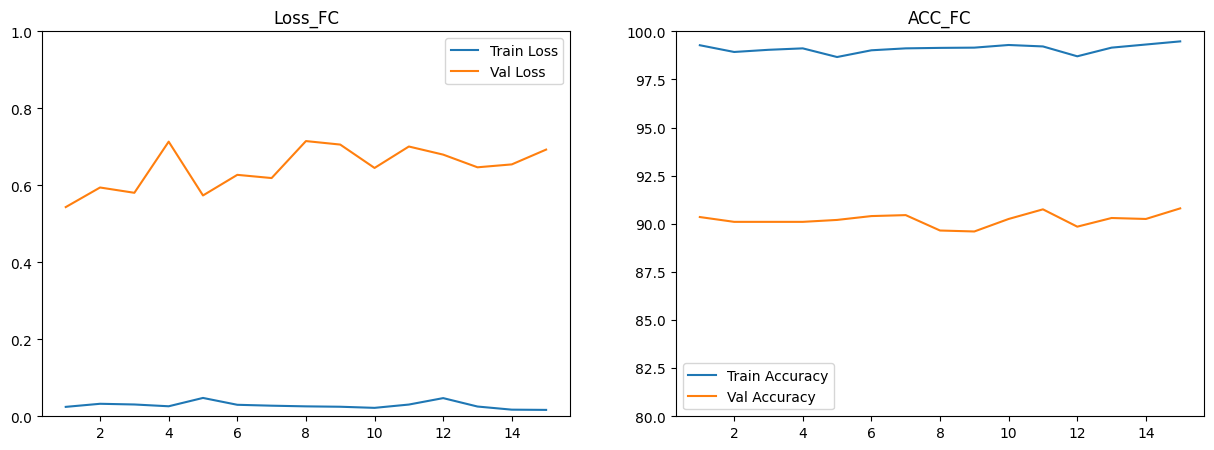

In [31]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model_CNN, train_loader, optimizer_CNN)
  val_loss, val_accuracy = evaluate(model_CNN, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss_FC')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC_FC')

plt.show()

## 결론을 작성해주세요:

NN 모델을 Dropout을 적용하지 않은 FC(Fully Connected), Dropout을 적용한 FC_dropout, CNN 세 가지로 구현하여 성능을 비교해 보았다. \

각 모델에 He initialization을 통해 가중치 초기화를 진행했다. \

또한 nn 은닉층의 input vector의 batch normalization을 진행하였다.

ReLU에서 발생하는 죽은 뉴런 문제를 완화하기 위해 LeakyReLU 활성화함수를 이용하였다. \

옵티마이저 함수로 Adam을 이용하였다. \

최종 Epoch에서 Val Accuracy로 평가한 성능은 CNN(90.8%) > FC(87.5%) > FC_dropout(85.8%) 순으로 나타났다. \

CNN이 이미지의 특징을 효과적으로 추출하기에 성능이 가장 높게 도출됐고, batchnorm을 진행한 input data에다가 dropout까지 적용한 FC_dropout은 학습 데이터에 과소적합되어 성능이 가장 낮게 나타난 것 같다.